Code used to calculate and plot data from lab 1


In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display

# Optional: cleaner default plot style
plt.style.use("seaborn-v0_8-whitegrid")


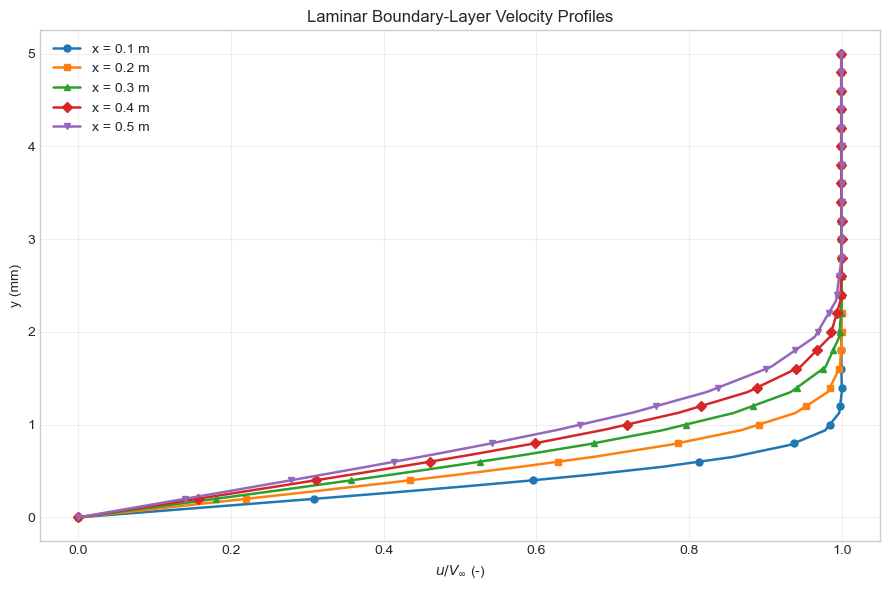

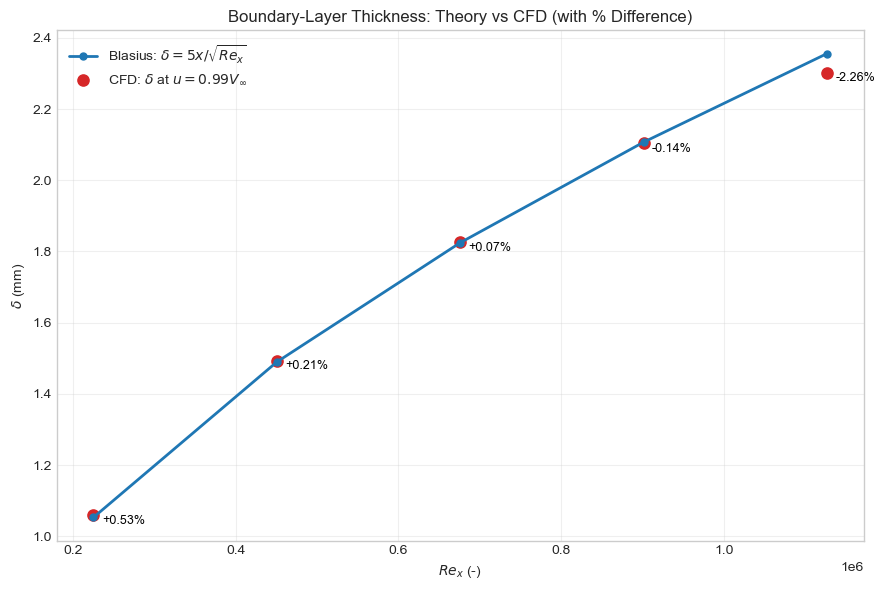


Final Results Table
x (m) V∞_profile (m/s) δ_CFD (mm)   Rex (-) δ_Blasius (mm) % diff (CFD vs Blasius)
  0.1         1.001500     1.0590 2.253e+05         1.0534                  +0.53%
  0.2         1.001200     1.4929 4.506e+05         1.4898                  +0.21%
  0.3         1.001200     1.8259 6.758e+05         1.8246                  +0.07%
  0.4         1.001200     2.1038 9.011e+05         2.1069                  -0.14%
  0.5         1.000900     2.3022 1.126e+06         2.3556                  -2.26%


In [14]:

# Inputs from csv files

data_dir = Path("data")
files = [data_dir / f"line_data{i}.csv" for i in range(1, 6)]

# directory to save plots
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)

# Freestream properties
V_inf_given = 30.0        # m/s
rho_inf = 1.2886          # kg/m^3
mu_inf = 1.716e-5         # N*s/m^2


# Process each x-location
rows = []

plt.figure(figsize=(9, 6))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
markers = ["o", "s", "^", "D", "v"]

for i, f in enumerate(files):
    df = pd.read_csv(f, usecols=["Points:0", "Points:1", "Velocity:0"]).apply(
        pd.to_numeric, errors="coerce"
    ).dropna()

    x = float(df["Points:0"].iloc[0])

    # Post-process: average duplicate y-values (if present), then sort by y
    prof = (
        df.groupby("Points:1", as_index=False)["Velocity:0"]
        .mean()
        .sort_values("Points:1")
        .reset_index(drop=True)
    )

    y = prof["Points:1"].to_numpy()      # m
    u = prof["Velocity:0"].to_numpy()    # m/s

    # Profile-based V∞ for normalization and delta criterion
    V_inf_profile = float(np.max(u))
    u_over_Vinf = u / V_inf_profile
    y_mm = y * 1000.0

    # Part 1 plot: velocity profile
    plt.plot(
        u_over_Vinf, y_mm,
        color=colors[i], marker=markers[i], markevery=40, linewidth=1.8, ms=5,
        label=f"x = {x:.1f} m"
    )

    # Part 2: delta where u = 0.99*V∞ (linear interpolation)
    u_target = 0.99 * V_inf_profile
    idxs = np.where(u >= u_target)[0]
    if len(idxs) == 0:
        delta_cfd_m = np.nan
    else:
        idx = int(idxs[0])
        if idx == 0:
            delta_cfd_m = float(y[0])
        else:
            y0, y1 = y[idx - 1], y[idx]
            u0, u1 = u[idx - 1], u[idx]
            if np.isclose(u1, u0):
                delta_cfd_m = float(y1)
            else:
                delta_cfd_m = float(y0 + (u_target - u0) * (y1 - y0) / (u1 - u0))

    # Part 3: Rex with given freestream properties
    Rex = rho_inf * V_inf_given * x / mu_inf

    # Part 4: Blasius delta = 5x/sqrt(Rex)
    delta_blasius_m = 5.0 * x / np.sqrt(Rex)

    # Part 5: percent difference
    pct_diff = (delta_cfd_m - delta_blasius_m) / delta_blasius_m * 100.0

    rows.append({
        "x (m)": x,
        "V∞_profile (m/s)": V_inf_profile,
        "δ_CFD (mm)": delta_cfd_m * 1000.0,
        "Rex (-)": Rex,
        "δ_Blasius (mm)": delta_blasius_m * 1000.0,
        "% diff (CFD vs Blasius)": pct_diff,
    })

# Finalize Part 1 plot
plt.xlabel(r"$u/V_\infty$ (-)")
plt.ylabel("y (mm)")
plt.title("Laminar Boundary-Layer Velocity Profiles")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / "velocity_profiles.pdf", format="pdf", bbox_inches="tight")
plt.show()


# -----------------------------
# Final table
# -----------------------------
results = pd.DataFrame(rows).sort_values("x (m)").reset_index(drop=True)

# Theory vs CFD plot with percent-difference labels

plt.figure(figsize=(9, 6))

# Theoretical curve
plt.plot(
    results["Rex (-)"], results["δ_Blasius (mm)"],
    "-o", color="tab:blue", linewidth=2, ms=5,
    label=r"Blasius: $\delta=5x/\sqrt{Re_x}$"
)

# CFD points
plt.scatter(
    results["Rex (-)"], results["δ_CFD (mm)"],
    s=65, color="tab:red", marker="o",
    label=r"CFD: $\delta$ at $u=0.99V_\infty$"
)

# Percent-difference annotations near CFD points
for _, r in results.iterrows():
    txt = f"{r['% diff (CFD vs Blasius)']:+.2f}%"
    plt.annotate(
        txt,
        (r["Rex (-)"], r["δ_CFD (mm)"]),
        textcoords="offset points",
        xytext=(6, -6),
        fontsize=9,
        color="black"
    )

plt.xlabel(r"$Re_x$ (-)")
plt.ylabel(r"$\delta$ (mm)")
plt.title("Boundary-Layer Thickness: Theory vs CFD (with % Difference)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / "delta_theory_vs_cfd.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Print one big clean table
print("\nFinal Results Table")
print(
    results.to_string(
        index=False,
        formatters={
            "x (m)": "{:.1f}".format,
            "V∞_profile (m/s)": "{:.6f}".format,
            "δ_CFD (mm)": "{:.4f}".format,
            "Rex (-)": "{:.3e}".format,
            "δ_Blasius (mm)": "{:.4f}".format,
            "% diff (CFD vs Blasius)": "{:+.2f}%".format,
        }
    )
)
